In [241]:
import os
import glob
import torch
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore")

In [242]:
dataset_path = "/home/btp/pkb_btp_1/gesture_reco/dataset"
image_data = []
for i, label in enumerate(os.listdir(dataset_path)):
    labelwise_image_path = os.path.join(dataset_path, label)
    images = glob.glob(os.path.join(labelwise_image_path, "*.jpg"))
    data = zip(images, [i]*len(images), [label]*len(images))
    for j in data:
        image_dict = {'path': j[0], 'label': j[1], 'label_names': j[2]}
        image_data.append(image_dict)

print(len(image_data))

78


In [243]:
seed = 43
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
epochs = 100
batch_size = 16
lr = 0.01
weight_decay = 0.001
image_size = 64
dataset_path = "/home/btp/pkb_btp_1/gesture_reco/dataset"

In [244]:
class GestureDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, train=True):
        self.dataset_path = dataset_path
        self.train = train
        self.image_data = []
        for i, label in enumerate(os.listdir(dataset_path)):
            labelwise_image_path = os.path.join(dataset_path, label)
            images = glob.glob(os.path.join(labelwise_image_path, "*.jpg"))
            data = zip(images, [i]*len(images), [label]*len(images))
            for j in data:
                image_dict = {'path': j[0], 'label': j[1], 'label_names': j[2]}
                self.image_data.append(image_dict)
                
        self.transform = transforms.Compose([
                            transforms.Resize((image_size, image_size)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        
        random.seed(19)
        random.shuffle(self.image_data)
        if self.train:
            self.image_data = self.image_data[0:60]
        else:
            self.image_data = self.image_data[60:-1]

    def __getitem__(self, index):
        image_dict = self.image_data[index]
        img = Image.open(image_dict['path'])
        img = self.transform(img)
        return {'image': img, 'label': image_dict['label']}
        
    
    def __len__(self):
        return len(self.image_data)

In [245]:
train_dataset = GestureDataset(dataset_path, train=True)
test_dataset =  GestureDataset(dataset_path, train=False)

In [246]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True, num_workers=0)

In [247]:
data = next(iter(train_dataloader))
data['label']

tensor([1, 0, 0, 3, 1, 2, 0, 1, 1, 0, 1, 2, 0, 3, 0, 3])

In [248]:
class NN_model(nn.Module):
    def __init__(self):
        super(NN_model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=4, stride=2)
        self.conv4 = nn.Conv2d(in_channels=8, out_channels=1, kernel_size=(3, 6), stride=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)
        x = x.view(x.shape[0], -1)
        return x

In [249]:
model = NN_model()

In [250]:
criterion = nn.CrossEntropyLoss()

In [236]:
loss = criterion(model(data['image']), data['label'])

In [237]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

In [238]:
losses = []
accuracy = []
for i in range(epochs):
    iter_dataloader = iter(train_dataloader)
    all_labels = []
    all_preds = []
    for j in range(len(train_dataset)//batch_size):
        data = next(iter_dataloader)
        images = data["image"]
        labels = data["label"]
        
        preds = model(images)
        loss = criterion(preds, labels)
        
        loss.backward() 
        optimizer.step() 
        optimizer.zero_grad() 
        losses.append(loss.data)
        
        all_labels.append(labels)
        all_preds.append(preds)
        
    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)
    epoch_acc = accuracy_score(all_labels, torch.argmax(all_preds, axis=1).numpy())
    epoch_pre = precision_recall_fscore_support(all_labels, torch.argmax(all_preds, axis=1).numpy())
    accuracy.append(epoch_acc)
    if i%10 == 0:
        print("Epoch", i, "Accuracy", epoch_acc, "Precision Recall Scores", epoch_pre)
        print("---------------------------------------------------------------------------------------------------")
    
data = next(iter(test_dataloader))
images = data["image"]
labels = data["label"]

preds = model(images)
test_acc = accuracy_score(labels, torch.argmax(preds, axis=1).numpy())
print("Maximum train accuracy is", max(accuracy))
print("Final test accuracy is", test_acc)

Epoch 0 Accuracy 0.125 Precision Recall Scores (array([0.2173913 , 0.09090909, 0.        , 0.        ]), array([0.3125    , 0.11111111, 0.        , 0.        ]), array([0.25641026, 0.1       , 0.        , 0.        ]), array([16,  9,  9, 14]))
---------------------------------------------------------------------------------------------------
Epoch 10 Accuracy 0.6041666666666666 Precision Recall Scores (array([0.56521739, 0.45454545, 0.        , 1.        ]), array([0.76470588, 0.625     , 0.        , 0.73333333]), array([0.65      , 0.52631579, 0.        , 0.84615385]), array([17,  8,  8, 15]))
---------------------------------------------------------------------------------------------------
Epoch 20 Accuracy 0.6458333333333334 Precision Recall Scores (array([0.57692308, 0.7       , 0.        , 1.        ]), array([0.83333333, 0.77777778, 0.        , 0.69230769]), array([0.68181818, 0.73684211, 0.        , 0.81818182]), array([18,  9,  8, 13]))
----------------------------------------

In [239]:
print(labels, torch.argmax(preds, axis=1).numpy())

tensor([2, 2, 2, 2, 0, 3, 0, 0, 3, 3, 1, 0, 2, 1, 3, 3, 0]) [2 2 2 2 0 3 0 1 3 3 1 0 2 1 3 3 0]


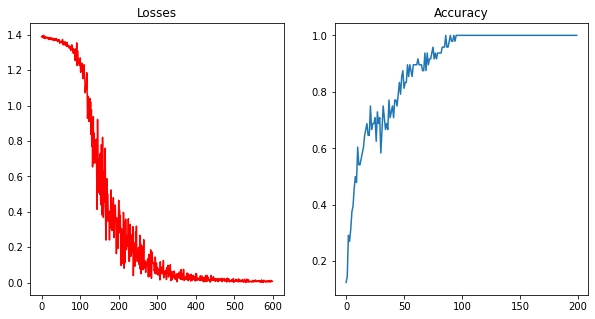

In [240]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, '-r')
plt.title("Losses")
plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(accuracy)
plt.show()

#### With lr 0.01, wd=0.001
### Maximum train accuracy is 0.9791666666666666
### Final test accuracy is 1.0